In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865


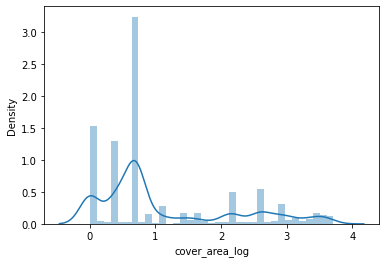

In [10]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [11]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [12]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [13]:
len(features)

3159

In [14]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]

In [15]:
len(features)

309

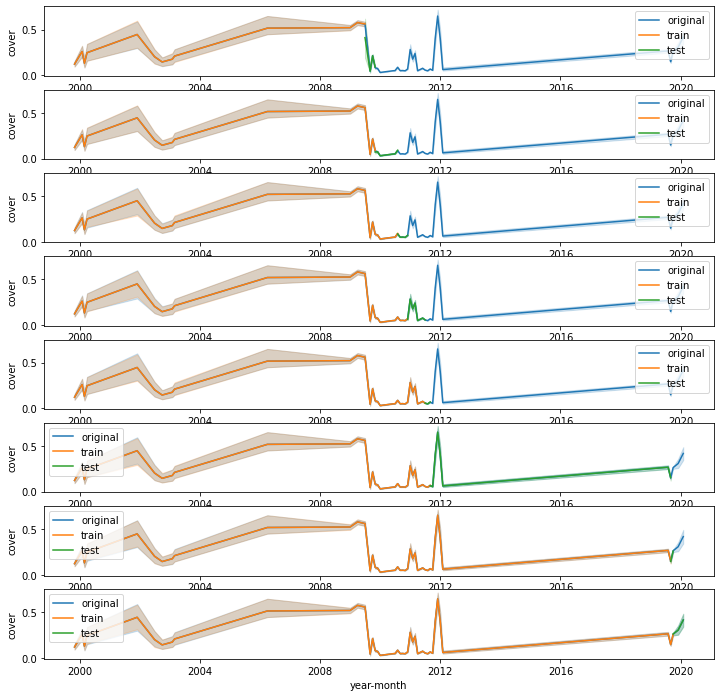

In [16]:
from sklearn.model_selection import TimeSeriesSplit

fig, axes = plt.subplots(8, 1, figsize=(12, 12))

train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)

folds = TimeSeriesSplit(n_splits=8)

for i, (train_index, test_index) in enumerate(folds.split(train)):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[i], label='original')
    # 学習用データを描く
    sns.lineplot(data=train.iloc[train_index], x='year-month', y='cover', ax=axes[i], label='train')
    # テスト用データを描く
    sns.lineplot(data=train.iloc[test_index], x='year-month', y='cover', ax=axes[i], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [17]:
#!pip install iterative-stratification

In [18]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [19]:
class CFG:
  ver=51
  model="lightgbm"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover"
  fold_target3="cover"

In [20]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df, fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[train_index, f'tr_fold{n}'] = 1
      df.loc[val_index, 'va_fold'] = int(n)
      df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
      df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [21]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [22]:
#features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
#features.remove("month")
features.append("mesh20")

In [23]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":6000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

In [24]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [25]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [26]:
#model1 = lgb.LGBMClassifier(**params1)
#flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [27]:
#match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
#display(match_results_df)

In [28]:
#match_id = match_results_df.Ctl.tolist()
#match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
#display(match_train)

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.218124
[400]	valid_0's rmse: 0.188422
[600]	valid_0's rmse: 0.180046
[800]	valid_0's rmse: 0.173751
[1000]	valid_0's rmse: 0.172113
[1200]	valid_0's rmse: 0.169153
[1400]	valid_0's rmse: 0.166758
[1600]	valid_0's rmse: 0.164729
[1800]	valid_0's rmse: 0.165659
[2000]	valid_0's rmse: 0.164768
[2200]	valid_0's rmse: 0.164417
[2400]	valid_0's rmse: 0.164104
[2600]	valid_0's rmse: 0.162956
[2800]	valid_0's rmse: 0.162911
[3000]	valid_0's rmse: 0.162561
[3200]	valid_0's rmse: 0.162135
[3400]	valid_0's rmse: 0.161703
[3600]	valid_0's rmse: 0.161691
[3800]	valid_0's rmse: 0.161814
[4000]	valid_0's rmse: 0.161423
[4200]	valid_0's rmse: 0.161493
[4400]	valid_0's rmse: 0.161633
[4600]	valid_0's rmse: 0.161259
[4800]	valid_0's rmse: 0.160994
[5000]	valid_0's rmse: 0.161018
[5200]	valid_0's rmse: 0.160888
[5400]	valid_0's rmse: 0.160898
[5600]	valid_0's rmse: 0.160829
[5800]	valid_0's rmse: 0.160808
[6000]	valid_0's rmse: 0.160795


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.16069247396659947
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.106503
[400]	valid_0's rmse: 0.0946998
[600]	valid_0's rmse: 0.093789
[800]	valid_0's rmse: 0.0939402
[1000]	valid_0's rmse: 0.0938164
[1200]	valid_0's rmse: 0.0938505
[1400]	valid_0's rmse: 0.0942591
[1600]	valid_0's rmse: 0.094478
[1800]	valid_0's rmse: 0.0945363
[2000]	valid_0's rmse: 0.0947482
[2200]	valid_0's rmse: 0.0947619
[2400]	valid_0's rmse: 0.0948255
[2600]	valid_0's rmse: 0.0949112
[2800]	valid_0's rmse: 0.0949554
[3000]	valid_0's rmse: 0.0948058
[3200]	valid_0's rmse: 0.0948618
[3400]	valid_0's rmse: 0.0949747
[3600]	valid_0's rmse: 0.0948788
[3800]	valid_0's rmse: 0.0947397
[4000]	valid_0's rmse: 0.0947223
[4200]	valid_0's rmse: 0.0946603
[4400]	valid_0's rmse: 0.0947655
[4600]	valid_0's rmse: 0.09473
[4800]	valid_0's rmse: 0.094761
[5000]	valid_0's rmse: 0.0947278
[5200]	valid_0's rmse: 0.0947555
[5400]	valid_0's rmse: 0.0947136
[5600]	valid_0's rmse: 0.094668
[5800]	valid_0's rmse: 0.0947267
[6000]	valid_0's rmse: 0.0946134


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.09461125276417627
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.14612
[400]	valid_0's rmse: 0.145399
[600]	valid_0's rmse: 0.145455
[800]	valid_0's rmse: 0.144624
[1000]	valid_0's rmse: 0.145228
[1200]	valid_0's rmse: 0.143435
[1400]	valid_0's rmse: 0.142646
[1600]	valid_0's rmse: 0.14095
[1800]	valid_0's rmse: 0.139983
[2000]	valid_0's rmse: 0.13901
[2200]	valid_0's rmse: 0.138822
[2400]	valid_0's rmse: 0.138104
[2600]	valid_0's rmse: 0.13771
[2800]	valid_0's rmse: 0.137417
[3000]	valid_0's rmse: 0.137591
[3200]	valid_0's rmse: 0.13736
[3400]	valid_0's rmse: 0.136963
[3600]	valid_0's rmse: 0.136366
[3800]	valid_0's rmse: 0.136086
[4000]	valid_0's rmse: 0.135969
[4200]	valid_0's rmse: 0.135739
[4400]	valid_0's rmse: 0.13546
[4600]	valid_0's rmse: 0.13532
[4800]	valid_0's rmse: 0.13506
[5000]	valid_0's rmse: 0.134911
[5200]	valid_0's rmse: 0.134744
[5400]	valid_0's rmse: 0.134349
[5600]	valid_0's rmse: 0.133913
[5800]	valid_0's rmse: 0.133515
[6000]	valid_0's rmse: 0.133259


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.1331363468008163
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.10714
[400]	valid_0's rmse: 0.119843
[600]	valid_0's rmse: 0.126115
[800]	valid_0's rmse: 0.128667
[1000]	valid_0's rmse: 0.128555
[1200]	valid_0's rmse: 0.126901
[1400]	valid_0's rmse: 0.128187
[1600]	valid_0's rmse: 0.128819
[1800]	valid_0's rmse: 0.126894
[2000]	valid_0's rmse: 0.127998
[2200]	valid_0's rmse: 0.12855
[2400]	valid_0's rmse: 0.129096
[2600]	valid_0's rmse: 0.128977
[2800]	valid_0's rmse: 0.128503
[3000]	valid_0's rmse: 0.130011
[3200]	valid_0's rmse: 0.129606
[3400]	valid_0's rmse: 0.130107
[3600]	valid_0's rmse: 0.129736
[3800]	valid_0's rmse: 0.129678
[4000]	valid_0's rmse: 0.129322
[4200]	valid_0's rmse: 0.12924
[4400]	valid_0's rmse: 0.12905
[4600]	valid_0's rmse: 0.129198
[4800]	valid_0's rmse: 0.128592
[5000]	valid_0's rmse: 0.128627
[5200]	valid_0's rmse: 0.128499
[5400]	valid_0's rmse: 0.1281
[5600]	valid_0's rmse: 0.127826
[5800]	valid_0's rmse: 0.127306
[6000]	valid_0's rmse: 0.126975


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.12697463375909163
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.109332
[400]	valid_0's rmse: 0.115226
[600]	valid_0's rmse: 0.118025
[800]	valid_0's rmse: 0.119638
[1000]	valid_0's rmse: 0.119389
[1200]	valid_0's rmse: 0.117221
[1400]	valid_0's rmse: 0.1164
[1600]	valid_0's rmse: 0.116443
[1800]	valid_0's rmse: 0.116434
[2000]	valid_0's rmse: 0.117445
[2200]	valid_0's rmse: 0.117848
[2400]	valid_0's rmse: 0.118084
[2600]	valid_0's rmse: 0.118535
[2800]	valid_0's rmse: 0.118938
[3000]	valid_0's rmse: 0.120094
[3200]	valid_0's rmse: 0.119729
[3400]	valid_0's rmse: 0.120556
[3600]	valid_0's rmse: 0.120037
[3800]	valid_0's rmse: 0.119897
[4000]	valid_0's rmse: 0.119525
[4200]	valid_0's rmse: 0.11956
[4400]	valid_0's rmse: 0.119547
[4600]	valid_0's rmse: 0.119724
[4800]	valid_0's rmse: 0.119325
[5000]	valid_0's rmse: 0.119207
[5200]	valid_0's rmse: 0.119657
[5400]	valid_0's rmse: 0.119672
[5600]	valid_0's rmse: 0.119726
[5800]	valid_0's rmse: 0.119595
[6000]	valid_0's rmse: 0.119821


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.11982070166267156
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.0613886
[400]	valid_0's rmse: 0.074264
[600]	valid_0's rmse: 0.0789714
[800]	valid_0's rmse: 0.0881709
[1000]	valid_0's rmse: 0.0888451
[1200]	valid_0's rmse: 0.0888604
[1400]	valid_0's rmse: 0.0907643
[1600]	valid_0's rmse: 0.0903138
[1800]	valid_0's rmse: 0.090222
[2000]	valid_0's rmse: 0.0901598
[2200]	valid_0's rmse: 0.0889086
[2400]	valid_0's rmse: 0.0901912
[2600]	valid_0's rmse: 0.090742
[2800]	valid_0's rmse: 0.0896356
[3000]	valid_0's rmse: 0.0896539
[3200]	valid_0's rmse: 0.089025
[3400]	valid_0's rmse: 0.0902668
[3600]	valid_0's rmse: 0.0899055
[3800]	valid_0's rmse: 0.0897288
[4000]	valid_0's rmse: 0.0892979
[4200]	valid_0's rmse: 0.088692
[4400]	valid_0's rmse: 0.0885494
[4600]	valid_0's rmse: 0.0888842
[4800]	valid_0's rmse: 0.0886395
[5000]	valid_0's rmse: 0.0882238
[5200]	valid_0's rmse: 0.087853
[5400]	valid_0's rmse: 0.0880726
[5600]	valid_0's rmse: 0.0876708
[5800]	valid_0's rmse: 0.0875598
[6000]	valid_0's rmse: 0.0870222


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.08702221736943615
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.185239
[400]	valid_0's rmse: 0.179263
[600]	valid_0's rmse: 0.176416
[800]	valid_0's rmse: 0.174929
[1000]	valid_0's rmse: 0.175428
[1200]	valid_0's rmse: 0.17554
[1400]	valid_0's rmse: 0.175141
[1600]	valid_0's rmse: 0.175669
[1800]	valid_0's rmse: 0.175941
[2000]	valid_0's rmse: 0.175694
[2200]	valid_0's rmse: 0.175415
[2400]	valid_0's rmse: 0.17532
[2600]	valid_0's rmse: 0.175518
[2800]	valid_0's rmse: 0.175581
[3000]	valid_0's rmse: 0.175668
[3200]	valid_0's rmse: 0.175559
[3400]	valid_0's rmse: 0.175358
[3600]	valid_0's rmse: 0.175409
[3800]	valid_0's rmse: 0.175385
[4000]	valid_0's rmse: 0.175293
[4200]	valid_0's rmse: 0.175562
[4400]	valid_0's rmse: 0.175478
[4600]	valid_0's rmse: 0.175539
[4800]	valid_0's rmse: 0.175454
[5000]	valid_0's rmse: 0.175486
[5200]	valid_0's rmse: 0.175357
[5400]	valid_0's rmse: 0.175481
[5600]	valid_0's rmse: 0.175464
[5800]	valid_0's rmse: 0.175408
[6000]	valid_0's rmse: 0.175551


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.17555139016820984
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.0596929
[400]	valid_0's rmse: 0.0584926
[600]	valid_0's rmse: 0.0579812
[800]	valid_0's rmse: 0.0584771
[1000]	valid_0's rmse: 0.0583197
[1200]	valid_0's rmse: 0.0579774
[1400]	valid_0's rmse: 0.0573853
[1600]	valid_0's rmse: 0.0575187
[1800]	valid_0's rmse: 0.0578377
[2000]	valid_0's rmse: 0.0580677
[2200]	valid_0's rmse: 0.0582117
[2400]	valid_0's rmse: 0.0581458
[2600]	valid_0's rmse: 0.0582222
[2800]	valid_0's rmse: 0.0583833
[3000]	valid_0's rmse: 0.0585186
[3200]	valid_0's rmse: 0.0586577
[3400]	valid_0's rmse: 0.0587278
[3600]	valid_0's rmse: 0.0588043
[3800]	valid_0's rmse: 0.058729
[4000]	valid_0's rmse: 0.0586817
[4200]	valid_0's rmse: 0.0587434
[4400]	valid_0's rmse: 0.058809
[4600]	valid_0's rmse: 0.0588439
[4800]	valid_0's rmse: 0.058825
[5000]	valid_0's rmse: 0.0587649
[5200]	valid_0's rmse: 0.058766
[5400]	valid_0's rmse: 0.0587549
[5600]	valid_0's rmse: 0.0587604
[5800]	valid_0's rmse: 0.0586307
[6000]	valid_0's rmse: 0.0586937


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.05869417628796474
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.129918
[400]	valid_0's rmse: 0.142869
[600]	valid_0's rmse: 0.145599
[800]	valid_0's rmse: 0.14989
[1000]	valid_0's rmse: 0.150868
[1200]	valid_0's rmse: 0.151792
[1400]	valid_0's rmse: 0.153984
[1600]	valid_0's rmse: 0.155248
[1800]	valid_0's rmse: 0.154687
[2000]	valid_0's rmse: 0.156501
[2200]	valid_0's rmse: 0.157688
[2400]	valid_0's rmse: 0.158358
[2600]	valid_0's rmse: 0.158781
[2800]	valid_0's rmse: 0.15949
[3000]	valid_0's rmse: 0.159745
[3200]	valid_0's rmse: 0.161255
[3400]	valid_0's rmse: 0.161616
[3600]	valid_0's rmse: 0.162067
[3800]	valid_0's rmse: 0.162116
[4000]	valid_0's rmse: 0.162041
[4200]	valid_0's rmse: 0.162482
[4400]	valid_0's rmse: 0.162037
[4600]	valid_0's rmse: 0.162464
[4800]	valid_0's rmse: 0.162682
[5000]	valid_0's rmse: 0.162464
[5200]	valid_0's rmse: 0.162522
[5400]	valid_0's rmse: 0.16271
[5600]	valid_0's rmse: 0.162591
[5800]	valid_0's rmse: 0.162519
[6000]	valid_0's rmse: 0.162588


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.16258818494597868
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.0719183
[400]	valid_0's rmse: 0.0702998
[600]	valid_0's rmse: 0.0698081
[800]	valid_0's rmse: 0.0671916
[1000]	valid_0's rmse: 0.067
[1200]	valid_0's rmse: 0.0665519
[1400]	valid_0's rmse: 0.0661486
[1600]	valid_0's rmse: 0.0655559
[1800]	valid_0's rmse: 0.0646122
[2000]	valid_0's rmse: 0.0643964
[2200]	valid_0's rmse: 0.0640832
[2400]	valid_0's rmse: 0.0638179
[2600]	valid_0's rmse: 0.0636088
[2800]	valid_0's rmse: 0.0634543
[3000]	valid_0's rmse: 0.0632529
[3200]	valid_0's rmse: 0.0632629
[3400]	valid_0's rmse: 0.0631347
[3600]	valid_0's rmse: 0.0629979
[3800]	valid_0's rmse: 0.0630737
[4000]	valid_0's rmse: 0.0630937
[4200]	valid_0's rmse: 0.062936
[4400]	valid_0's rmse: 0.0628535
[4600]	valid_0's rmse: 0.0627153
[4800]	valid_0's rmse: 0.0625518
[5000]	valid_0's rmse: 0.0624404
[5200]	valid_0's rmse: 0.0624097
[5400]	valid_0's rmse: 0.0624489
[5600]	valid_0's rmse: 0.0624175
[5800]	valid_0's rmse: 0.0624182
[6000]	valid_0's rmse: 0.0623191


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.062311909873346706
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.251104
[400]	valid_0's rmse: 0.246925
[600]	valid_0's rmse: 0.247714
[800]	valid_0's rmse: 0.252487
[1000]	valid_0's rmse: 0.252722
[1200]	valid_0's rmse: 0.254444
[1400]	valid_0's rmse: 0.256164
[1600]	valid_0's rmse: 0.255548
[1800]	valid_0's rmse: 0.254261
[2000]	valid_0's rmse: 0.254937
[2200]	valid_0's rmse: 0.254866
[2400]	valid_0's rmse: 0.255131
[2600]	valid_0's rmse: 0.254186
[2800]	valid_0's rmse: 0.25381
[3000]	valid_0's rmse: 0.254485
[3200]	valid_0's rmse: 0.253608
[3400]	valid_0's rmse: 0.252752
[3600]	valid_0's rmse: 0.252602
[3800]	valid_0's rmse: 0.253436
[4000]	valid_0's rmse: 0.253356
[4200]	valid_0's rmse: 0.253295
[4400]	valid_0's rmse: 0.252557
[4600]	valid_0's rmse: 0.251998
[4800]	valid_0's rmse: 0.25145
[5000]	valid_0's rmse: 0.250779
[5200]	valid_0's rmse: 0.250271
[5400]	valid_0's rmse: 0.250132
[5600]	valid_0's rmse: 0.249819
[5800]	valid_0's rmse: 0.249127
[6000]	valid_0's rmse: 0.248944


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.24894370323465123
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.221161
[400]	valid_0's rmse: 0.221781
[600]	valid_0's rmse: 0.225916
[800]	valid_0's rmse: 0.230276
[1000]	valid_0's rmse: 0.228687
[1200]	valid_0's rmse: 0.228454
[1400]	valid_0's rmse: 0.230407
[1600]	valid_0's rmse: 0.231819
[1800]	valid_0's rmse: 0.232889
[2000]	valid_0's rmse: 0.235041
[2200]	valid_0's rmse: 0.235067
[2400]	valid_0's rmse: 0.234312
[2600]	valid_0's rmse: 0.23356
[2800]	valid_0's rmse: 0.233285
[3000]	valid_0's rmse: 0.233249
[3200]	valid_0's rmse: 0.234368
[3400]	valid_0's rmse: 0.234081
[3600]	valid_0's rmse: 0.233938
[3800]	valid_0's rmse: 0.23267
[4000]	valid_0's rmse: 0.232702
[4200]	valid_0's rmse: 0.232789
[4400]	valid_0's rmse: 0.231248
[4600]	valid_0's rmse: 0.231681
[4800]	valid_0's rmse: 0.230671
[5000]	valid_0's rmse: 0.229829
[5200]	valid_0's rmse: 0.229758
[5400]	valid_0's rmse: 0.229612
[5600]	valid_0's rmse: 0.22937
[5800]	valid_0's rmse: 0.229265
[6000]	valid_0's rmse: 0.228616


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.22861607203206455
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.286858
[400]	valid_0's rmse: 0.279408
[600]	valid_0's rmse: 0.277476
[800]	valid_0's rmse: 0.275507
[1000]	valid_0's rmse: 0.273556
[1200]	valid_0's rmse: 0.273292
[1400]	valid_0's rmse: 0.273446
[1600]	valid_0's rmse: 0.27292
[1800]	valid_0's rmse: 0.272971
[2000]	valid_0's rmse: 0.271975
[2200]	valid_0's rmse: 0.271663
[2400]	valid_0's rmse: 0.271657
[2600]	valid_0's rmse: 0.271868
[2800]	valid_0's rmse: 0.271986
[3000]	valid_0's rmse: 0.271356
[3200]	valid_0's rmse: 0.271237
[3400]	valid_0's rmse: 0.271215
[3600]	valid_0's rmse: 0.271641
[3800]	valid_0's rmse: 0.272166
[4000]	valid_0's rmse: 0.272024
[4200]	valid_0's rmse: 0.271765
[4400]	valid_0's rmse: 0.271898
[4600]	valid_0's rmse: 0.271943
[4800]	valid_0's rmse: 0.27222
[5000]	valid_0's rmse: 0.272412
[5200]	valid_0's rmse: 0.272406
[5400]	valid_0's rmse: 0.272474
[5600]	valid_0's rmse: 0.272748
[5800]	valid_0's rmse: 0.272704
[6000]	valid_0's rmse: 0.272659


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.27265868104652
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.232152
[400]	valid_0's rmse: 0.215493
[600]	valid_0's rmse: 0.208607
[800]	valid_0's rmse: 0.202154
[1000]	valid_0's rmse: 0.199543
[1200]	valid_0's rmse: 0.198059
[1400]	valid_0's rmse: 0.196592
[1600]	valid_0's rmse: 0.19561
[1800]	valid_0's rmse: 0.194779
[2000]	valid_0's rmse: 0.194007
[2200]	valid_0's rmse: 0.193472
[2400]	valid_0's rmse: 0.193825
[2600]	valid_0's rmse: 0.193069
[2800]	valid_0's rmse: 0.193084
[3000]	valid_0's rmse: 0.192752
[3200]	valid_0's rmse: 0.192565
[3400]	valid_0's rmse: 0.192329
[3600]	valid_0's rmse: 0.192522
[3800]	valid_0's rmse: 0.192302
[4000]	valid_0's rmse: 0.19203
[4200]	valid_0's rmse: 0.191824
[4400]	valid_0's rmse: 0.191721
[4600]	valid_0's rmse: 0.191608
[4800]	valid_0's rmse: 0.19145
[5000]	valid_0's rmse: 0.191402
[5200]	valid_0's rmse: 0.191268
[5400]	valid_0's rmse: 0.191186
[5600]	valid_0's rmse: 0.191065
[5800]	valid_0's rmse: 0.190936
[6000]	valid_0's rmse: 0.190908


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.19090798953204707
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.8/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's rmse: 0.220065
[400]	valid_0's rmse: 0.201468
[600]	valid_0's rmse: 0.194337
[800]	valid_0's rmse: 0.189417
[1000]	valid_0's rmse: 0.187346
[1200]	valid_0's rmse: 0.185463
[1400]	valid_0's rmse: 0.185847
[1600]	valid_0's rmse: 0.185183
[1800]	valid_0's rmse: 0.185209
[2000]	valid_0's rmse: 0.185301
[2200]	valid_0's rmse: 0.186709
[2400]	valid_0's rmse: 0.186829
[2600]	valid_0's rmse: 0.186745
[2800]	valid_0's rmse: 0.186469
[3000]	valid_0's rmse: 0.186403
[3200]	valid_0's rmse: 0.186735
[3400]	valid_0's rmse: 0.186855
[3600]	valid_0's rmse: 0.186784
[3800]	valid_0's rmse: 0.187028
[4000]	valid_0's rmse: 0.186997
[4200]	valid_0's rmse: 0.187218
[4400]	valid_0's rmse: 0.187434
[4600]	valid_0's rmse: 0.187417
[4800]	valid_0's rmse: 0.187581
[5000]	valid_0's rmse: 0.187699
[5200]	valid_0's rmse: 0.187971
[5400]	valid_0's rmse: 0.187731
[5600]	valid_0's rmse: 0.187667
[5800]	valid_0's rmse: 0.187638
[6000]	valid_0's rmse: 0.187669


<ipython-input-24-4ad0bb16ed8b>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.18767180751261964


,feature,importance
241,lat,0.031315
216,lon,0.021172
156,warm_sst,0.020779
75,fetch,0.014837
26,MIN_D678_500,0.014493
94,river_dist,0.014372
39,hist_warm_sst,0.013834
3,sst_ymd,0.012268
15,month,0.011119
105,MIN_GARI,0.011065


RMSE 0.16640906635951297


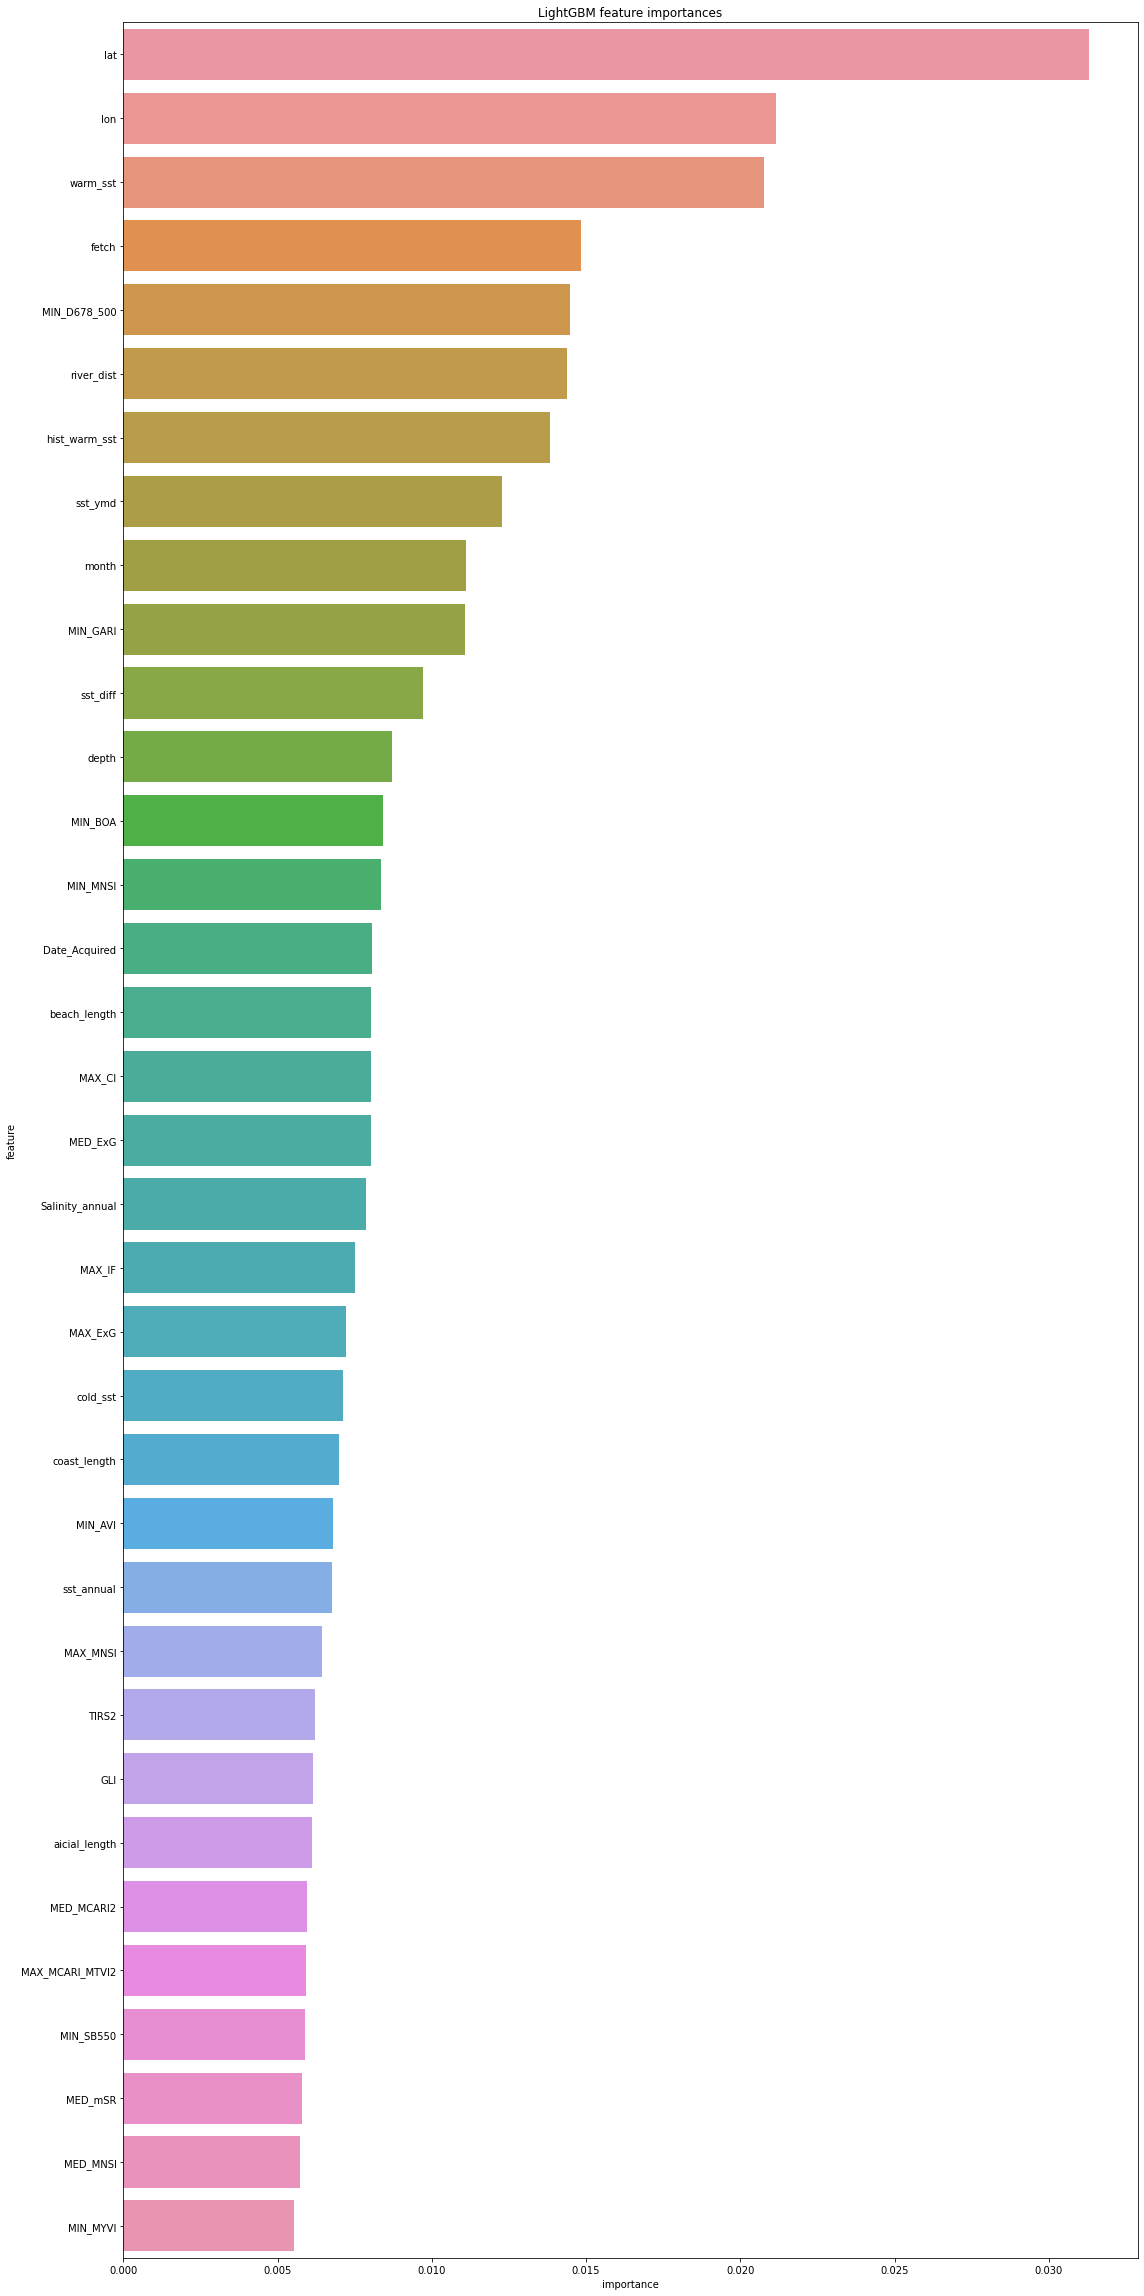

In [29]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [30]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["_pred"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.16640758104154418


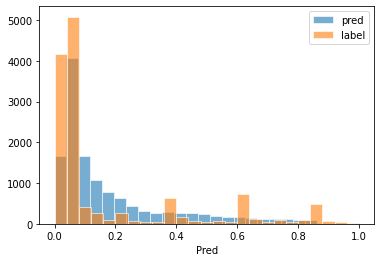

In [31]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [32]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,1,0.008418
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,1,0.151678
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,1,0.086910
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,0.071737
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,1,0.466658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,1,0.100348
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,1,0.074051
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,1,0.329096
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,1,0.145672


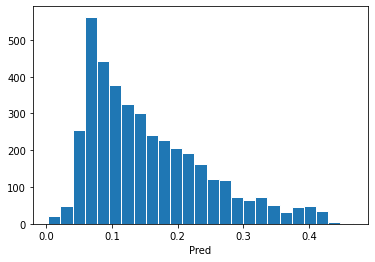

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20,1,0.008418
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20,1,0.151678
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23,1,0.086910
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,0.071737
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01,1,0.466658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,-0.187582,-0.861148,-3.207146,3.633575,60.936945,3.053976,-28.354402,4027_03,1,0.100348
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,-0.264021,-0.833596,-2.385447,2.495430,75.231230,3.946128,-2.112646,3624_20,1,0.074051
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-0.123194,-0.843974,-4.397375,4.403977,117.513676,1.904304,0.601280,3927_23,1,0.329096
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,-0.276085,-0.788681,-3.821984,2.203933,121.654726,2.282056,-2.029225,3623_03,1,0.145672


In [33]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)